# Machine Learning Module 4: Computational Graphs & Back Propagation
> Written by Nick Stanisha and Ryan Soklaski 

## Gradient-Based Learning Continued

In the previous unit, we learned about gradient descent and how it can be used to train a machine learning model. Specifically, we learned how to minimize loss functions of the form

\begin{equation}
L(\vec{X}, y; \vec{W})
\end{equation}

with respect to our model's _parameters_, which we denote as being stored in the vector $\vec{W}$. $\vec{X}$ is a vector whose components store each datum of the training dataset. $y$ stores the "truth-value" for that data, i.e. what the correct prediction/classification is for each training datum. A semicolon is used to separate $\vec{W}$, so as to indicate that these are the variables we are concerned with updating in order to minimize $L$. We then showed that by finding the values of $\vec{W}$ that minimize an appropriate formulation of $L$, our model could learn to accomplish all sorts of tasks (in the last unit, our model learned to predict box office sales from production and promotion expenses).

That being said, the models we have encountered have been exceedingly simple thus far. The model created in the previous module performed a simple linear mapping of the movie data, $\vec{X}$, to the predicted Box Office sales for the movies. Furthermore, the loss that we utilized was a simple mean-squared error formula. In total, this made it very easy for us to compute both the model's forward-pass (i.e. $\hat{y} = \vec{W} \cdot \vec{X}$), and the gradient of the loss, $\nabla L$. What will we do if we encounter a more nuanced problem involving far more rich and sophisticated data? For instance, what if $\vec{X}$ is an image and our task is to predict a label for the content of that image? Can you think of a simple mathematical function that will allow our model to map an image's pixel-values to predictive scores, weighting the likelihood that the picture is of a cat vs. dog vs. mouse?

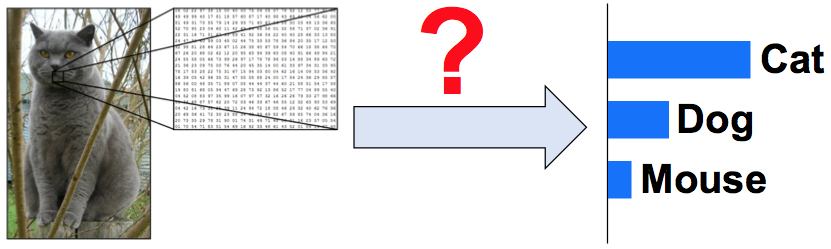

`* cat image from https://cs231n.github.io/classification/`

## Composite Functions

If your answer to that question was "no", you are not alone. Analytically expressing a single function that takes an image as its input and outputs a distribution of prediction-scores over labels is not an easy task at first glance. In fact, we will argue that it is disadvantageous to tackle this sort of problem head-on. Instead, the accepted approach for designing the forward-pass of a model is to _chain functions together_, repeatedly transforming the data until the desired output is finally reached. Programmatically, you could imagine chaining a series of operations together, where each operation acts on the output of the previous one.

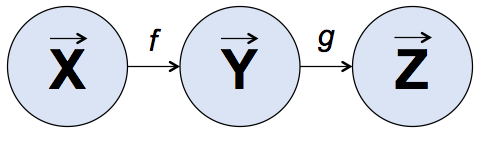

Mathematically, this is actually constructing a **composite function**, i.e. a function of the form

\begin{equation}
\vec{Z} = g(f(\vec{X}))
\end{equation}

or, equivalently

\begin{equation}
\vec{Z} = (g \circ f)(\vec{X})
\end{equation}

where $\circ$ is the [composition operator](https://en.wikipedia.org/wiki/Function_composition). We can chain functions together in this manner to create increasingly complex transformations of our data, to produce our model's predictions, $\hat{y}$.

\begin{equation}
\hat{y} = (p \circ q \circ \ldots g \circ f)(\vec{X})
\end{equation}

Then, just like before, we can score our output with a loss function

\begin{equation}
L(y, \hat{y})
\end{equation}

Keep in mind that the intermediate functions, $p, q, ..., g, f$ are what introduce our parameters, $\vec{W}$. Thus $\hat{y}$ depends on both $\vec{X}$ and $\vec{W}$, which accounts for original form for $L$: $L(\vec{X}, y; \vec{W})$ 

Composition is a natural approach to take when designing a model for several reasons, all of which hinge on the concept of *modularity*:

* _Generality_: Any function $f$ designed to serve a role in one composite model can be easily repurposed for another model, provided that the form of its inputs and outputs remain unchanged.
* _Simplicity_: It is conceptually easier to talk about smaller, independent transformations. Furthermore, it is convenient to mathematically express your model as a series of function compositions
* _Code quality_: It is easier to ensure that the various aspects of your model are operating correctly when you are able to decompose it into pieces that can be tested independently.
* _Elegance_: The nature of Calculus is such that taking a derivative of a composite function begets a simple, systematic computational process to be followed (known as the "chain rule"). Not only is this amenable to an elegant symbolic representation, but it is also simple to implement algorithmically.

The final point on this list emphasizes one of the main thrusts of this module: not only does designing a machine learning model using function-composition afford us the listed benefits of modularity, which allow us to add "layers" to our models without incurring a dramatic increase in complexity, but it also provides us with a completely general method for computing $\nabla L$. **A detailed summary of the chain rule, and its generalization for functions of multible variables, is provided in the supplemental material that is provided with this reading. Please review it carefully.** If you are not familiar with partial derivatives, please refer to the supplemental materials included in the previous module.

A rigorous mathematical justification for _why_ it is permittable to restrict our models to the family of composed functions — that is, why we don't worry that the convenience of modularity will stifle us — is outside of the scope of this unit. Broadly speaking, it has to do with model _complexity_ and _learnability_. Using composite functions retains the _complexity_ of any single conceivable function, but significantly decreases the number of parameters that must be learned. The net result is that using composite functions leads to shorter training times and models that are able to learn more effectively with less data.

## Composite Functions for Machine Learning & Back-Propagation
Recall from the previous module that in order to be used in conjuntion with the gradient descent method, both our model's forward-pass function and our loss function must be differentiable. A generic forward-pass function and loss function, which are used to perform our model's task and to test its success, respectively, can be represented via function-composition as:

\begin{equation}
\hat{y}(\vec{W}, x) = (f_n \circ f_{n-1} \ldots \circ f_1)(x)
\end{equation}
\begin{equation}
L = F(y, \hat{y})
\end{equation}

where $f_1,  ..., f_{n-1}, f_n,$ and $F$ are all differentiable functions.

So the general form of the forward-pass function can be written as:

\begin{equation}
\hat{y} = f_{N}(f_{N-1}(\ldots (f_{2}(f_{1}(x, \vec{W}_{1}), \vec{W}_{2}) \ldots ), \vec{W}_{N-1}), \vec{W}_{N})
\end{equation}

where $\vec{W_j}$ simply represents the collection of all the learnable parameters that belong to the function $f_j$ (packaged as a vector). Given this formula, you may have a hunch as to what people mean when they refer to the "layers" of a neural network. We will refer to $f_j$ as the jth "layer" of our model.

Let's concoct an example to help make this notation more concrete. Suppose there are three "layers" to our model's forward-pass function:
\begin{align}
f_1(x; w_{1}^{(1)}, w_{1}^{(2)}) &= w_{1}^{(1)}x + w_{1}^{(2)}x^2 \\
f_2(x; w_{2}) &= w_{2}x^{-1} \\
f_3(x; w_{3}) &= w_{3} + x \\
\end{align}

and suppose we have an exceedingly simply loss function, where, unrealistically, we do not even make use of any "truth-data".

\begin{align}
L(x) = x^2
\end{align}

The details of these functions are meaningless beyond explicitly illustrating some roles that learnable parameters can play in them, and showing that a single function can possess multiple parameters. Thus our model's forward-pass, and the resulting loss, are:
\begin{equation}
\hat{y}(x; \vec{W}) = f_{3}(f_{2}(f_{1}(x, \vec{W}_{1}), \vec{W}_{2}) ), \vec{W}_{3})) = w_3 + w_{2}(w_{1}^{(1)}x + w_{1}^{(2)}x^2)^{-1}
\end{equation}

\begin{equation}
L(x; \vec{W}) = (w_3 + w_{2}(w_{1}^{(1)}x + w_{1}^{(2)}x^2)^{-1})^2
\end{equation}


where we used vectors to "package up" each function's parameters merely as a matter of notational convenience:
\begin{align}
\vec{W}_{1} &= [w_{1}^{(1)}, w_{1}^{(2)}] \\
\vec{W}_{2} &= [w_{2}] \\
\vec{W}_{3} &= [w_{3}] \\ 
\vec{W} &= [w_{1}^{(1)}, w_{1}^{(2)}, w_{2}, w_{3}]
\end{align}



Returning to the lesson at large (we will refer back to our example soon), the challenge is now to compute  $\nabla L$ given our formulation of $\hat{y}$. This requires us to compute the partial derivative of $L$ with respect to **each** learnable parameter in our model's forward-pass function. This is precisely where we make use of the **chain rule**. The following is the equation for the partial derivative of our loss, with respect to the k-th parameter of layer-j, $w_{j}^{(k)}$:

\begin{equation}
\frac{\partial L}{\partial w_{j}^{(k)}} = \frac{\partial{L}}{\partial{f_n}}\frac{\partial{f_n}}{\partial{f_{n-1}}}\ldots \frac{\partial{f_{j+1}}}{\partial f_j}\frac{\partial f_j}{\partial w_{j}^{(k)}}
\end{equation}

**It is critical to see that this expression can be simplified by invoking the chain rule yet again - this time, to collapse the equation rather than expand it**
\begin{equation}
\frac{\partial L}{\partial w_{j}^{(k)}} = \frac{\partial{L}}{\partial{f_j}}\frac{\partial f_j}{\partial w_{j}^{(k)}}
\end{equation}

Thus you can compute $\frac{\partial L}{\partial w_{j}^{(k)}}$ for any of layer-j's weights by first computing the partial derivative of the loss with respect to the output of that layer: $\frac{\partial{L}}{\partial{f_j}}$. Then, you multiply it with $\frac{\partial f_j}{\partial w_{j}^{(k)}}$, which is computed for that specific weight. Note, however, that we can easily compute $\frac{\partial{L}}{\partial{f_j}}$ if we already know $\frac{\partial{L}}{\partial{f_{j+1}}}$:
\begin{equation}
\frac{\partial L}{\partial f_j} = \frac{\partial{L}}{\partial{f_{j+1}}}\frac{\partial f_{j+1}}{\partial f_j}
\end{equation}

This idea of using the derivative involving layer $j+1$ in order to compute the derivative involving layer $j$ naturally leads us to the identify the process called **back-propagation**. This is a convenient way to compute all of the relevant partial derivatives to ultimately construct $\nabla L$.

### Back Propagation
**Back-propagation** provides a series of steps to take in order to compute $\frac{\partial L}{\partial w_{j}^{(k)}}$ for any parameter, $k$, of any layer, $j$:
 - Compute $\frac{\partial L}{\partial f_n}$, corresponding to the outer-most layer of your model.
 - Compute $\frac{\partial L}{\partial w_{n}^{(k)}} = \frac{\partial L}{\partial f_n}\frac{\partial f_n}{\partial w_{n}^{(k)}}$ for all of the parameters belonging to layer $n$.
 - Using $\frac{\partial L}{\partial f_n}$, compute $\frac{\partial L}{\partial f_{n-1}} = \frac{\partial L}{\partial f_n}\frac{\partial f_n}{\partial f_{n-1}}$
 - Compute $\frac{\partial L}{\partial w_{n-1}^{(k)}} = \frac{\partial L}{\partial f_{n-1}}\frac{\partial f_{n-1}}{\partial w_{n}^{(k)}}$ for all of the parameters belonging to layer $n - 1$.
 - Using $\frac{\partial L}{\partial f_{n-1}}$, compute $\frac{\partial L}{\partial f_{n-2}} = \frac{\partial L}{\partial f_{n-1}}\frac{\partial f_{n-1}}{\partial f_{n-2}}$
 - Compute $\frac{\partial L}{\partial w_{n-2}^{(k)}} = \frac{\partial L}{\partial f_{n-2}}\frac{\partial f_{n-2}}{\partial w_{n}^{(k)}}$ for all of the parameters belonging to layer $n - 2$.
 - Continue this process for all remaining layers in descending order: $n - 3, ..., 2, 1$


Let's return to example of our 3-layer model, and work through the back-propagation. Remember, ultimately we want to compute:

\begin{equation}
\nabla_{\vec{W}} L = [\frac{\partial L}{\partial w_{1}^{(1)}}, \frac{\partial L}{\partial w_{1}^{(2)}}, \frac{\partial L}{\partial w_{2}}, \frac{\partial L}{\partial w_{3}}]
\end{equation}

According to back-propagation, we should start with layer 3 and compute $\frac{\partial L}{\partial f_3}$ (for whatever function $L$ we choose). Armed with this, we compute the derivative involving layer 3's parameter: 

\begin{align*}
\frac{\partial L}{\partial w_{3}} &= \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial w_{3}} \\
\end{align*}

Next, we move to layer 2. We must compute $\frac{\partial f_3}{\partial f_2}$ and utilize $\frac{\partial L}{\partial f_3}$, so that we can compute:
\begin{align*}
\frac{\partial L}{\partial f_2} &= \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial f_2}
\end{align*}

This enables us to compute the derivative involving layer 2's parameter:
\begin{align*}
\frac{\partial L}{\partial w_{2}} &= \frac{\partial L}{\partial f_2}\frac{\partial f_2}{\partial w_{2}}\\
\end{align*}

Finally, we iterate the same process, but for layer 1:
\begin{align*}
\frac{\partial L}{\partial f_1} &= \frac{\partial L}{\partial f_2}\frac{\partial f_2}{\partial f_1}
\end{align*}

This finally helps us to compute the derivatives for **both** of layer-1's parameters:
\begin{align*}
\frac{\partial L}{\partial w_{1}^{(1)}} &= \frac{\partial L}{\partial f_1}\frac{\partial f_1}{\partial w_{1}^{(1)}} \\
\frac{\partial L}{\partial w_{1}^{(2)}} &= \frac{\partial L}{\partial f_1}\frac{\partial f_1}{\partial w_{1}^{(2)}} \\
\end{align*}

Let's not forget why we are doing all of this. Computing the gradient allows us to update the values of our learnable parameters via the gradient-descent process, so that the next forward pass on the same data will (hopefully) produce "better" results:
\begin{align*}
\vec{W}_{new} = \vec{W}_{old} - \delta \nabla L
\end{align*}

This was a rather comprehensive look at the forward-pass and back-propagation in the abstract. In the next section you will be see how the process of carrying out these computations can be facilitated, conceptually at least, by thinking in terms of a **computational graph** whose nodes are variables and operations, and whose edges indicate their relationships. While many find this process to be useful, be mindful of the fact that it is ultimately just a rehash of the chain rule and nothing more.

## Computing the Numerical Gradient
If we want to leverage composite functions for machine learning, we'll need to think of a practical way to compute gradients. Specifically, we'll need to employ a method that computes the derivative of $L$ _at a particular value of_ $\vec{W}$, say, $\vec{W} = \vec{W_{c}}$, corresponding to the current state of our model's parameters, and given a particular piece of training data, $x = x_{c}$. That is, we do not need to compute the _functional form_ of the gradient, only its *value* given the current values of our model's parameters and our training data. Think back to the blindfolded hiker analogy for gradient descent -  we only assess the topology of where we are currently standing to decide our next move. 

The approach for doing this will involve two main steps

* **forward pass**: Using the current values of $x = x_{c}$ and $\vec{W} = \vec{W}_{c}$, compute $\hat{y}$
* **back propagation**: Use $\hat{y}$ to compute $L$. Then, using back-propagation, compute the **evaluated** derivatives as you work backwards through the layers. $\frac{\partial L}{\partial W_j}\Bigr|_{(x_{c}; \vec{W}_{c})}$, so as to arrive at the value of $\nabla L = [..., \frac{\partial L}{\partial W_j}\Bigr|_{(x_{c}; \vec{W}_{c})}, ...]$.

Taking from the example in the previous section, suppose $\vec{W}_{c} = [-1.2, 3.1, 4.0 , 10]$ and $x_c = 2.5$, we compute

\begin{align*}
\frac{\partial L}{\partial f_3}\Bigr|_{(x_{c}; \vec{W}_{c})}
\end{align*}

which is a *number*  - we evaluated the function $\frac{\partial L}{\partial f_3}$ at $(x_{c}; \vec{W}_{c})$.

We then compute the number  $\frac{\partial f_3}{\partial w_3}\Bigr|_{(x_{c}; \vec{W}_{c})}$ and multiply these two value to arrive at a concrete number to plug into our gradient:
\begin{align*}
\frac{\partial L}{\partial w_3}\Bigr|_{(x_{c}; \vec{W}_{c})} = \frac{\partial L}{\partial f_3}\Bigr|_{(x_{c}; \vec{W}_{c})}\frac{\partial f_3}{\partial w_3}\Bigr|_{(x_{c}; \vec{W}_{c})}
\end{align*}

Obviously, we are still abiding by the back-propagation scheme, we are simply evaluating our derivatives with specific values for the model parameters and training data as we back-propagate. Ultimately we construct a **numerical-vector** (as opposed to a vector of functions) for $\nabla L$:
\begin{equation}
\nabla_{\vec{W}} L = \left[\frac{\partial L}{\partial w_{1}^{(1)}}\Bigr|_{(x_{c}; \vec{W}_{c})}, \frac{\partial L}{\partial w_{1}^{(2)}}\Bigr|_{(x_{c}; \vec{W}_{c})}, \frac{\partial L}{\partial w_{2}}\Bigr|_{(x_{c}; \vec{W}_{c})}, \frac{\partial L}{\partial w_{3}}\Bigr|_{(x_{c}; \vec{W}_{c})}\right]
\end{equation}



### Envisioning a Computational Graph & Auto-Differentiation

As mentioned earlier, people often find it useful to envision a _computational graph_, when learning how to compute the forward and backward pass for a model. A computational graph is a collection of _vertices_ representing variables and operations and _edges_ which represent dependencies. Additionally, this will serve as a valuable framework for understanding how to design an auto-differentiation framework, which is the object of your homework. For this, you will write Python classes to describe the variables and operations of a computational graph so that you can perform the forward pass and back propagation effortlessly!

As an example, examine the compuational graph below which represents the following composite function.


\begin{equation}
\lambda(x, y) = x + y\\
F(\lambda, z) = \lambda \times z
\end{equation}

and evaluate the forward pass as $x = 3$, $y = 5$, and $z = 2$: $F(\lambda(3, 5), 2))$.

#### Forward Pass
We necessarily traverse the graph from left to right, computing the _forward-pass_  of the graph, which concludes by assigning a value to the variable $F$.


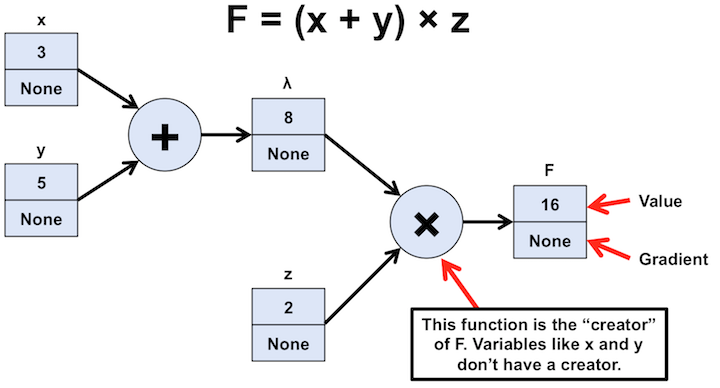

In this graph, circular vertices represent _bivariate operations_ (i.e. functions that take two variables as inputs, which we will be dealing with exclusively for this unit), and square vertices represent the _current values of the graph's variables_, which include the independent variables, $x, y, z$, as well as the dependent variables $\lambda$ and $F$. 



#### Back-Propagation
Performing back propagation on this computational graph follows the exact pattern laid out in the earlier section on back propagation. It entails computing all of the partial derivatives of $F$, evaluated at $x = 3$, $y = 5$, and $z = 2$: $\frac{\partial F}{\partial x}\Bigr|_{x=3, y=5, z=2} $, $\frac{\partial F}{\partial y}\Bigr|_{x=3, y=5, z=2}$, $\frac{\partial F}{\partial z}\Bigr|_{x=3, y=5, z=2}$, and $\frac{\partial F}{\partial \lambda}\Bigr|_{x=3, y=5, z=2}$. These are the $x, y, z$, and $\lambda$-components of the gradient $\nabla F$, respectively. Again, we will drop the vertical line "evaluation" notation just for the sake of simplicity. We will always be evaluating our partial derivatives using the current numerical values of our variables, which we computed during the forward-pass.

We will actually also "compute" $\frac{\partial F}{\partial F}$, which is always 1 by identity. The reason why we do this will be a matter of algorithmic convenience: $F$ is a variable no different than $\lambda$ or $x$, so we will compute $F$'s gradient in the same way we do for the other variables. In this way all variables will be treated the same. 

As we saw above, the chain rule tells us that we can achieve this most easily by proceeding from *right to left* (pictured below) across the graph, hence the name back propagation.

\begin{align*}
\frac{\partial{F}}{\partial{F}} &= 1 \\
\frac{\partial{F}}{\partial{z}} &= \frac{\partial{F}}{\partial{F}}\frac{\partial{F}}{\partial{z}} = \frac{\partial{(\lambda \cdot z)}}{\partial{z}} = \lambda = 8 \\
\frac{\partial{F}}{\partial{\lambda}} &= \frac{\partial{F}}{\partial{F}}\frac{\partial{F}}{\partial{\lambda}} = \frac{\partial{(\lambda \cdot z)}}{\partial{\lambda}} = z = 2 \\
\frac{\partial{F}}{\partial{x}} &= \frac{\partial{F}}{\partial{F}}\frac{\partial{F}}{\partial{\lambda}} \frac{\partial{\lambda}}{\partial{x}} = 2 \cdot \frac{\partial{(x + y)}}{\partial{x}} = 2 \\
\frac{\partial{F}}{\partial{y}} &= \frac{\partial{F}}{\partial{F}}\frac{\partial{F}}{\partial{\lambda}} \frac{\partial{\lambda}}{\partial{y}} = 2 \cdot \frac{\partial{(x + y)}}{\partial{y}} = 2 \\
\end{align*}

Again, the $\frac{\partial{F}}{\partial{F}}$ terms are only included for the sake of consistency. They contribute nothing to the results.

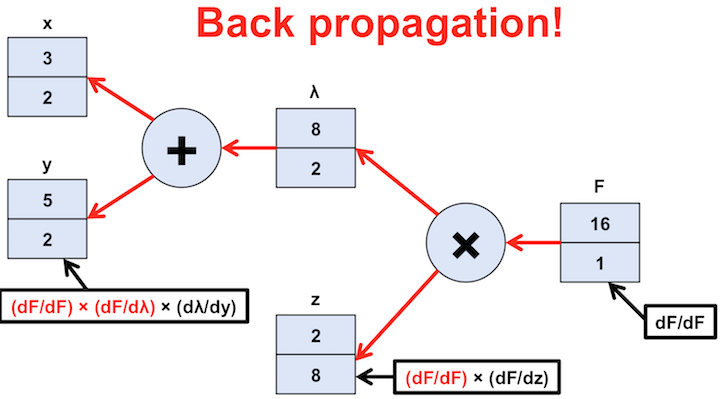

There are a few important points to note:
 - The value for $\frac{\partial{F}}{\partial{\lambda}}$, "propagates backwards", affecting $\frac{\partial{F}}{\partial{x}}$ and $\frac{\partial{F}}{\partial{y}}$, because $x$ and $y$ both are connected to $\lambda$ via an "operation node".
 - The fact that $z$ is completely "disconnected" (i.e. independent) from $x$ and $y$ is why its partial derivative does not contribute to their partials. If x was connected to both $\lambda$ and $z$, then its partial derivative would have been $\frac{\partial{F}}{\partial{x}} = \frac{\partial{F}}{\partial{F}}\frac{\partial{F}}{\partial{\lambda}} \frac{\partial{\lambda}}{\partial{x}} + \frac{\partial{F}}{\partial{F}}\frac{\partial{F}}{\partial{z}} \frac{\partial{z}}{\partial{x}}$. The lack of connection between $x$ and $z$, via an operation node in the graph, allows us to conclude that $\frac{\partial{z}}{\partial{x}} = 0$. If this does not make sense, please review the multivariable chain rule in the supplemental materials.
 - Although the values of $x$ and $y$ did not explicitly appear in their derivatives, as a quirk of this particular example, they did directly determine $\lambda$, whose value impacted their derivatives.


Armed with these partial derivatives, we compute the _value_ of the gradient _at the particular coordinate_ ($(x=3, y=5, z=2)$ in the example above: $\nabla F = [2, 2, 8, 2] \rightarrow [\frac{\partial F}{\partial x}, \frac{\partial F}{\partial y}, \frac{\partial F}{\partial z}, \frac{\partial F}{\partial \lambda}]$. It is important to always keep in mind that **back propagation does not derive the functional form of the gradient -- only a particular value of the gradient**.  Thankfully, that's all we need in order to perform gradient descent and, by extension, train our machine learning model.

Next, we will formalize the process of performing back propagation as an algorithm (the forward pass is trivial).
Our goal is to create a framework of variables and operations that we can use to compute the gradient of any computational graph, and compute the forward pass and backpropagation (provided specific values for the graph's input variables) effortlessly. 

> **NOTE**: In our lecture material, we conflate multiple mathematical ideas into the square nodes. We assign them values and talk about them as if they are _variables_, but then turn right back around and compute quantities like $\frac{\partial{F}}{\partial{z}}$ as if they were _functions_. If this gets confusing (and it almost surely will), imagine instead that the square nodes represent _variables with memory_. Once we implement back propagation, we will assume that all variables _remember how they were computed_ and use this knowledge to compute the current value of the derivative. For instance, after the forward pass, $\lambda$ "knows" that it stores the value 8, and that it was created by the addition operator connected to $x$ and $y$.

### Back Propagation at an Algorithmic Level: Auto-Differentiation

In your assignment, you will implement an **auto-differentiation framework**. That is, you will implement a _variable_ class and an _operation_ class, which you can use to compose arbitrary computional graphs of variables connected by operations. Encoded in these classes is the ability to perform a forward pass and back propagation for any graph that you construct.

As a rule, the back propagation chain will always be started by calling `.backprop()` on a _variable_. Suppose we call `.backprop()` on the variable $F$, this will trigger the partial derivatives of $F$ to be computed with respect to *all of the preceding variables in the computational graph*.

The pseudo-code for such a framework is as follows:

```
variable.backprop(incoming_gradient)
    if current_gradient is None
        set current_gradient equal to incoming_gradient
    else
        add incoming_gradient to current_gradient
    
    if variable has a creator
        pass incoming_gradient to creator.backprop
      

operation.backprop(incoming_gradient)
    # We assume that every operation takes only two arguments: out = op(a, b)
    - Compute the partial derivative: d(op)/da (holding b constant)
    - Compute the partial derivative: d(op)/db (holding a constant)
    - Pass incoming_gradient * d(op)/da to a.backprop
    - Pass incoming_gradient * d(op)/db to b.backprop
```

Hopefully, this algorithm implementation will look familiar from our previous discussions of the chain rule. In particular, the line in `operation.backprop` where we pass `incoming_gradient * d(op)/da` back to `a` is our _explicit_ encoding of the chain rule ($\frac{d(f\circ g)}{dx} = \frac{df}{dg}\frac{dg}{dx}$). 

And the instruction in `variable.backprop` to *accumulate* the incoming gradient with the current one is an encoding of the multivariable chain rule ($\frac{\partial(f(p(x, y), q(x, y))}{\partial x} = \frac{\partial f}{\partial p}\frac{\partial p}{\partial x} + \frac{\partial f}{\partial q}\frac{\partial q}{\partial x}$)

Let's also realize that the instructions in `variable.backprop` to `add incoming_gradient to current_gradient` when the current value of our variable's gradient is not None, is simply an encoding of the **multivariable chain rule**. This is motivated and discussed in detail in the supplemental material, but it is still valuable to consult an illustration:

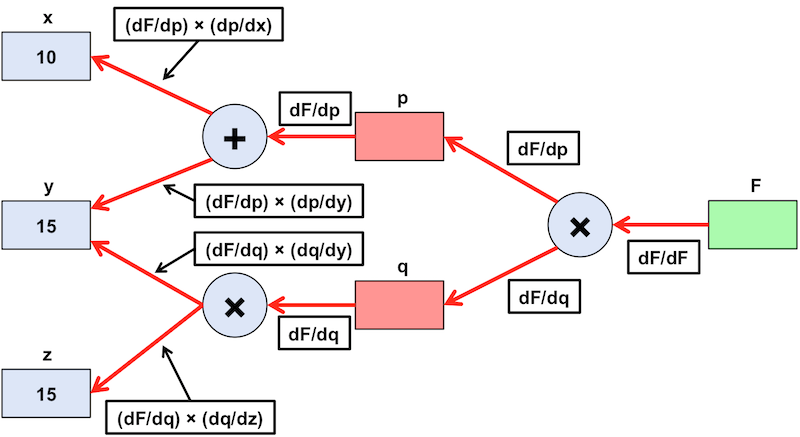

Since `y` is involved in more than one operation, there is more than one edge that leads to it. Notice that each path to y terminates by passing the product of all preceding derivatives along its path (i.e. the path $F\to p\to y$ will conclude by passing the incoming gradient $\frac{\partial F}{\partial p}\frac{\partial p}{\partial y}$ to $y$). We _add_ all of these quantities to compute the final derivative of $y$ because of the _multivariable chain rule_, i.e.

\begin{equation}
\frac{\partial F(p(x, y), q(y, z))}{\partial y} = \frac{\partial F}{\partial p}\frac{\partial p}{\partial y} + \frac{\partial F}{\partial q}\frac{\partial q}{\partial y}
\end{equation}

This is precisely the form of $F$ in the compuatational graph above. $F$ is a function of $p$ and $q$, which both depend on $y$. 

# Conclusion

We will conclude here with a brief discussion of "deep learning", a branch of machine learning that uses _neural networks_ with multiple _layers_ to learn complex representations of data. Deep learning has been in the news lately due to [numerous applications](https://en.wikipedia.org/wiki/Deep_learning#Applications) where it has achieved human or even _super-human_ performance. Although we haven't explicitly talked about "neural networks" or "deep learning" yet, we have already learned a lot about them. Consider the following image, which is a prototypical diagram of a deep neural network.

![two-layer net](src/neural_net.png)

It might surprise you to know that that diagram represents a _computational graph_, just like the ones we have been dealing with throughout this unit (the only difference is that edges in the graph above can represent any non-linear & differentiable dependency between nodes, not just [$+-\times\div$^]). In fact, the entire process of _training a state-of-the-art neural network_ only requires applying what we've already learned. Specifically, neural networks are trained using the following approach

1. Computing a **forward-pass** through _layers_ of the neural network is the process of utilizing **composite functions** to map input data to a final output prediction.
2. Score the output of the neural network with a **loss function**.
3. Use **back propagation** to  differentiate the loss function with respect to the **learnable parameters**
4. Make small adjustments to the learnable parameters using **gradient descent**.

We are very close now to being able to implement a neural network completely from scratch. In this week's programming assignment, you will create your own automatic differentiation library, which will perform back propagation for operations on scalars and support numerical operations ($+-\times\div$^). In the next unit, you will use a similar library that is capable of handling higher-dimensional data to construct your own deep neural network.

## More reading

If you would like more information about back propagation, check out the overview from Stanford's CS 231n [here](https://cs231n.github.io/optimization-2/).